In [1]:
# Set the working directory to the parent directory
import sys
sys.path.append('..')
sys.dont_write_bytecode = True

import os
os.chdir("..")

# Import relevant custom libraries
from src.eda import data_info
from src.models import AutoencoderTrainer, AnomalyDetector, AutoencoderTuner
from src.evaluation import ValidationEvaluation

# Import relevant libraries
import pandas as pd
import warnings
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from datetime import datetime
import re
import tensorflow as tf
import pickle
from datetime import datetime
import math
import glob

# Config
pd.set_option('display.max_columns', None) # Ensure all columns are displayed
warnings.filterwarnings("ignore")

In [2]:
# Read relevant files
X_train = pd.read_feather("data/processed/X_train.feather")
X_train_validate = pd.read_feather("data/processed/X_train_validate.feather")

# Get data info
var_info = data_info(X_train)
all_cols = X_train.columns
real_cols = var_info[var_info["var_type"]=="numerical"]["var_name"].tolist()
binary_cols = var_info[var_info["var_type"]=="binary"]["var_name"].tolist()

## 1. Test the trainer

In [3]:
"""epsilon = 5
delta = 1e-5

params = {'hidden_dims': (64,)
          , 'batch_size': 130
          , 'dropout_rate': 0.20478957748893
          , 'learning_rate': 0.0003920855375953398
          , 'lam': 0.08727224232404436
          , 'gamma': 0.35521226819521173
          , 'max_epochs': 682}

ae = AutoencoderTrainer(
    input_dim=X_train.shape[1],
    real_cols=real_cols,
    binary_cols=binary_cols,
    all_cols=all_cols,
    verbose=True,
    plot_losses=True,
    post_hoc=False,
    target_epsilon=epsilon,
    delta=delta,
    save_tracking=False,
    **params
)

autoencoder = ae.train(X_train, X_train_validate)"""

"epsilon = 5\ndelta = 1e-5\n\nparams = {'hidden_dims': (64,)\n          , 'batch_size': 130\n          , 'dropout_rate': 0.20478957748893\n          , 'learning_rate': 0.0003920855375953398\n          , 'lam': 0.08727224232404436\n          , 'gamma': 0.35521226819521173\n          , 'max_epochs': 682}\n\nae = AutoencoderTrainer(\n    input_dim=X_train.shape[1],\n    real_cols=real_cols,\n    binary_cols=binary_cols,\n    all_cols=all_cols,\n    verbose=True,\n    plot_losses=True,\n    post_hoc=False,\n    target_epsilon=epsilon,\n    delta=delta,\n    save_tracking=False,\n    **params\n)\n\nautoencoder = ae.train(X_train, X_train_validate)"

## 2. Test the anomaly detector

In [4]:
# Read relevant files
X_validate = pd.read_feather("data/processed/X_validate.feather")
y_validate = pd.read_feather("data/processed/y_validate.feather")

"""noise_mechanism = 'laplace'

# After training
detector = AnomalyDetector(
    model=autoencoder,
    real_cols=real_cols,
    binary_cols=binary_cols,
    all_cols=all_cols,
    lam=params['lam'],
    gamma=params['gamma'],
    post_hoc=True,
    noise_mechanism=noise_mechanism,
    target_epsilon=epsilon, delta=delta
)

noise_multiplier = 0.0181574764047888

# Compute scores
scores = detector._compute_anomaly_scores(x=X_validate, noise_multiplier=noise_multiplier)
print(scores)

# Detect
y_pred = detector._detect(scores, 9.9907783269882195)

# Evaluate
metrics = detector._evaluate(y_pred, y_validate, scores)
print(metrics)"""

"noise_mechanism = 'laplace'\n\n# After training\ndetector = AnomalyDetector(\n    model=autoencoder,\n    real_cols=real_cols,\n    binary_cols=binary_cols,\n    all_cols=all_cols,\n    lam=params['lam'],\n    gamma=params['gamma'],\n    post_hoc=True,\n    noise_mechanism=noise_mechanism,\n    target_epsilon=epsilon, delta=delta\n)\n\nnoise_multiplier = 0.0181574764047888\n\n# Compute scores\nscores = detector._compute_anomaly_scores(x=X_validate, noise_multiplier=noise_multiplier)\nprint(scores)\n\n# Detect\ny_pred = detector._detect(scores, 9.9907783269882195)\n\n# Evaluate\nmetrics = detector._evaluate(y_pred, y_validate, scores)\nprint(metrics)"

## 3. Hyperparameter Tuning

In [5]:
"""metric = 'auc'
n_calls = 4
random_starts = 3

# --- Define hyperparameter grid ---
base_grid = [0.001, 0.00005]
scaled_grid = [round(l * float(epsilon) ** 1.8, 3) for l in base_grid]
learning_rate_grid = [scaled_grid[0] + 0.00001, max(scaled_grid[1] - 0.00001, 1e-6)]
max_rate = min(learning_rate_grid[1], 0.1)
min_rate = max(learning_rate_grid[0], 1e-6)
param_grid = {
    'hidden_dims': [[64], [64, 32]],
    'batch_size': [64, 150],
    'dropout_rate': [0.0, 0.4],
    'learning_rate': [max_rate, min_rate],
    'lam': [1e-4, 1e-1],
    'gamma': [0.001, 0.999],
    'max_epochs': [150, 700],
}

# --- Initialize tuner object ---
tuner = AutoencoderTuner(
    x_train=X_train,
    x_train_val=X_train_validate,
    x_val=X_validate,
    y_val=y_validate,
    real_cols=real_cols,
    binary_cols=binary_cols,
    all_cols=all_cols,
    activation='relu',
    patience_limit=10,
    version=None,
    dp_sgd=False,
    target_epsilon=float(epsilon),
    delta=float(delta),
    continue_run=False,
    post_hoc=True,
    noise_mechanism=noise_mechanism,
    bo_estimator='GP',
)

# --- Perform tuning using selected strategy ---
best_model, best_params, best_score = tuner.bo_tune(
    param_grid,
    metric=metric,
    n_calls=n_calls,
    random_starts=random_starts,
    eval_num=int(max(2, 6-float(epsilon))),
)"""

"metric = 'auc'\nn_calls = 4\nrandom_starts = 3\n\n# --- Define hyperparameter grid ---\nbase_grid = [0.001, 0.00005]\nscaled_grid = [round(l * float(epsilon) ** 1.8, 3) for l in base_grid]\nlearning_rate_grid = [scaled_grid[0] + 0.00001, max(scaled_grid[1] - 0.00001, 1e-6)]\nmax_rate = min(learning_rate_grid[1], 0.1)\nmin_rate = max(learning_rate_grid[0], 1e-6)\nparam_grid = {\n    'hidden_dims': [[64], [64, 32]],\n    'batch_size': [64, 150],\n    'dropout_rate': [0.0, 0.4],\n    'learning_rate': [max_rate, min_rate],\n    'lam': [1e-4, 1e-1],\n    'gamma': [0.001, 0.999],\n    'max_epochs': [150, 700],\n}\n\n# --- Initialize tuner object ---\ntuner = AutoencoderTuner(\n    x_train=X_train,\n    x_train_val=X_train_validate,\n    x_val=X_validate,\n    y_val=y_validate,\n    real_cols=real_cols,\n    binary_cols=binary_cols,\n    all_cols=all_cols,\n    activation='relu',\n    patience_limit=10,\n    version=None,\n    dp_sgd=False,\n    target_epsilon=float(epsilon),\n    delta=floa

### 3.1. Tuning Implementation

In [6]:
#! python3.11 "scripts/posthoc_dp_model.py" --metric auc --n_calls=30 --noise_mechanism gaussian --epsilon 1 --delta 1e-5
#! python3.11 "scripts/posthoc_dp_model.py" --metric auc --n_calls=30 --noise_mechanism gaussian --epsilon 3 --delta 1e-5
#! python3.11 "scripts/posthoc_dp_model.py" --metric auc --n_calls=30 --noise_mechanism gaussian --epsilon 5 --delta 1e-5
#! python3.11 "scripts/posthoc_dp_model.py" --metric auc --n_calls=30 --noise_mechanism laplace --epsilon 1 --delta 1e-5
#! python3.11 "scripts/posthoc_dp_model.py" --metric auc --n_calls=30 --noise_mechanism laplace --epsilon 3 --delta 1e-5
#! python3.11 "scripts/posthoc_dp_model.py" --metric auc --n_calls=30 --noise_mechanism laplace --epsilon 5 --delta 1e-5
#! python3.11 "scripts/posthoc_dp_model.py" --metric f1_score --n_calls=30 --noise_mechanism gaussian --epsilon 1 --delta 1e-5
#! python3.11 "scripts/posthoc_dp_model.py" --metric f1_score --n_calls=30 --noise_mechanism gaussian --epsilon 3 --delta 1e-5
#! python3.11 "scripts/posthoc_dp_model.py" --metric f1_score --n_calls=30 --noise_mechanism gaussian --epsilon 5 --delta 1e-5
#! python3.11 "scripts/posthoc_dp_model.py" --metric f1_score --n_calls=30 --noise_mechanism laplace --epsilon 1 --delta 1e-5
#! python3.11 "scripts/posthoc_dp_model.py" --metric f1_score --n_calls=30 --noise_mechanism laplace --epsilon 3 --delta 1e-5
#! python3.11 "scripts/posthoc_dp_model.py" --metric f1_score --n_calls=30 --noise_mechanism laplace --epsilon 5 --delta 1e-5
#! python3.11 "scripts/posthoc_dp_model.py" --metric recall --n_calls=30 --noise_mechanism gaussian --epsilon 1 --delta 1e-5
#! python3.11 "scripts/posthoc_dp_model.py" --metric recall --n_calls=30 --noise_mechanism gaussian --epsilon 3 --delta 1e-5
#! python3.11 "scripts/posthoc_dp_model.py" --metric recall --n_calls=30 --noise_mechanism gaussian --epsilon 5 --delta 1e-5
#! python3.11 "scripts/posthoc_dp_model.py" --metric recall --n_calls=30 --noise_mechanism laplace --epsilon 1 --delta 1e-5
#! python3.11 "scripts/posthoc_dp_model.py" --metric recall --n_calls=30 --noise_mechanism laplace --epsilon 3 --delta 1e-5
#! python3.11 "scripts/posthoc_dp_model.py" --metric recall --n_calls=30 --noise_mechanism laplace --epsilon 5 --delta 1e-5
#! python3.11 "scripts/posthoc_dp_model.py" --metric precision --n_calls=30 --noise_mechanism gaussian --epsilon 1 --delta 1e-5
#! python3.11 "scripts/posthoc_dp_model.py" --metric precision --n_calls=30 --noise_mechanism gaussian --epsilon 3 --delta 1e-5
#! python3.11 "scripts/posthoc_dp_model.py" --metric precision --n_calls=30 --noise_mechanism gaussian --epsilon 5 --delta 1e-5
#! python3.11 "scripts/posthoc_dp_model.py" --metric precision --n_calls=30 --noise_mechanism laplace --epsilon 1 --delta 1e-5
#! python3.11 "scripts/posthoc_dp_model.py" --metric precision --n_calls=30 --noise_mechanism laplace --epsilon 3 --delta 1e-5
#! python3.11 "scripts/posthoc_dp_model.py" --metric precision --n_calls=30 --noise_mechanism laplace --epsilon 5 --delta 1e-5

### 3.2. Summarize the Performance on Validation Set

In [7]:
os.chdir("notebooks")
# Initialize the validation evaluation
valeval = ValidationEvaluation(X_validate, y_validate, real_cols, binary_cols, all_cols, dp_sgd=False, post_hoc=True)
    
# Read the log file
log_path = "../logs/posthoc_dp_tune_log.txt"

# Extract the latest successful Bayesian versions
latest_successful_versions = valeval.extract_latest_successful_bayesian_versions(log_path)
print(latest_successful_versions)

# Evaluate the model performance
eval_results = valeval.evaluate_model_performance(latest_successful_versions)
eval_results = eval_results[eval_results["epsilon"]>=1]

{'202505090042': ('AUC', 1.0, 1e-05, 'gaussian', datetime.datetime(2025, 5, 9, 1, 23, 38, 470990)), '202505090123': ('AUC', 3.0, 1e-05, 'gaussian', datetime.datetime(2025, 5, 9, 1, 52, 19, 860831)), '202505090152': ('AUC', 5.0, 1e-05, 'gaussian', datetime.datetime(2025, 5, 9, 2, 28, 7, 926573)), '202505090426': ('F1-Score', 1.0, 1e-05, 'gaussian', datetime.datetime(2025, 5, 9, 5, 8, 1, 821137)), '202505090508': ('F1-Score', 3.0, 1e-05, 'gaussian', datetime.datetime(2025, 5, 9, 5, 43, 32, 336949)), '202505090543': ('F1-Score', 5.0, 1e-05, 'gaussian', datetime.datetime(2025, 5, 9, 11, 42, 6, 992036)), '202505091312': ('Recall', 1.0, 1e-05, 'gaussian', datetime.datetime(2025, 5, 9, 14, 2, 26, 674412)), '202505091411': ('AUC', 1.0, 1e-05, 'laplace', datetime.datetime(2025, 5, 9, 15, 6, 29, 81849)), '202505091506': ('AUC', 3.0, 1e-05, 'laplace', datetime.datetime(2025, 5, 9, 15, 50, 23, 125940)), '202505091550': ('AUC', 5.0, 1e-05, 'laplace', datetime.datetime(2025, 5, 9, 16, 30, 29, 523076

In [8]:
eval_results

,precision,recall,f1_score,auc,accuracy,hidden_dims,batch_size,dropout_rate,learning_rate,lam,gamma,max_epochs,threshold,tuned_by,delta,epsilon,noise_mechanism,end_time
version,,,,,,,,,,,,,,,,,,
202505100506,0.777193,0.192191,0.308174,0.685617,0.826394,"(64, 32)",65.0,0.396156,0.007713,0.055332,0.852641,697.0,4.911293,Precision,0.00001,5.0,laplace,2025-05-10 05:44:43.819945
202505100339,0.751748,0.186551,0.298922,0.699417,0.823950,"(64,)",100.0,0.400000,0.000840,0.010443,0.330700,697.0,9.996907,Precision,0.00001,1.0,laplace,2025-05-10 04:25:15.291718
202505100247,0.781250,0.195228,0.312392,0.705279,0.827093,"(64,)",150.0,0.350470,0.017232,0.033702,0.100026,585.0,15.611747,Precision,0.00001,5.0,gaussian,2025-05-10 03:39:04.056578
202505100205,0.774869,0.192625,0.308548,0.703541,0.826307,"(64,)",116.0,0.332596,0.006769,0.036666,0.158459,644.0,15.406433,Precision,0.00001,3.0,gaussian,2025-05-10 02:47:10.828404
202505100107,0.777972,0.193059,0.309350,0.674230,0.826569,"(64, 32)",90.0,0.222458,0.001010,0.085389,0.781739,438.0,6.855632,Precision,0.00001,1.0,gaussian,2025-05-10 02:05:37.851975
202505100425,0.770578,0.190889,0.305981,0.658727,0.825783,"(64, 32)",103.0,0.118524,0.001392,0.093839,0.643282,360.0,10.747762,Precision,0.00001,3.0,laplace,2025-05-10 05:06:20.816987
202505100028,0.356955,0.531020,0.426927,0.696382,0.713188,"(64,)",83.0,0.342599,0.010234,0.033517,0.001327,391.0,9.132199,Recall,0.00001,5.0,laplace,2025-05-10 01:06:55.289090
202505091312,0.401897,0.588286,0.477549,0.730251,0.741032,"(64, 32)",109.0,0.000000,0.000469,0.100000,0.999000,700.0,0.364804,Recall,0.00001,1.0,gaussian,2025-05-09 14:02:26.674412
202505092146,0.394884,0.582646,0.470733,0.728816,0.736406,"(64, 32)",98.0,0.000000,0.007010,0.100000,0.999000,150.0,0.353577,Recall,0.00001,3.0,laplace,2025-05-10 00:28:40.459893


In [9]:
display(eval_results.sort_values(by=["tuned_by", "epsilon"], ascending=True)[['epsilon', 'tuned_by']])

,epsilon,tuned_by
version,,
202505100339,1.0,Precision
202505100107,1.0,Precision
202505100205,3.0,Precision
202505100425,3.0,Precision
202505100506,5.0,Precision
202505100247,5.0,Precision
202505091312,1.0,Recall
202505092102,1.0,Recall
202505092146,3.0,Recall


In [10]:
eval_results.to_csv("../experiments/perf_summary/posthoc_dp_val_results.csv")

### 3.3. Compare Models Based on Validation Set

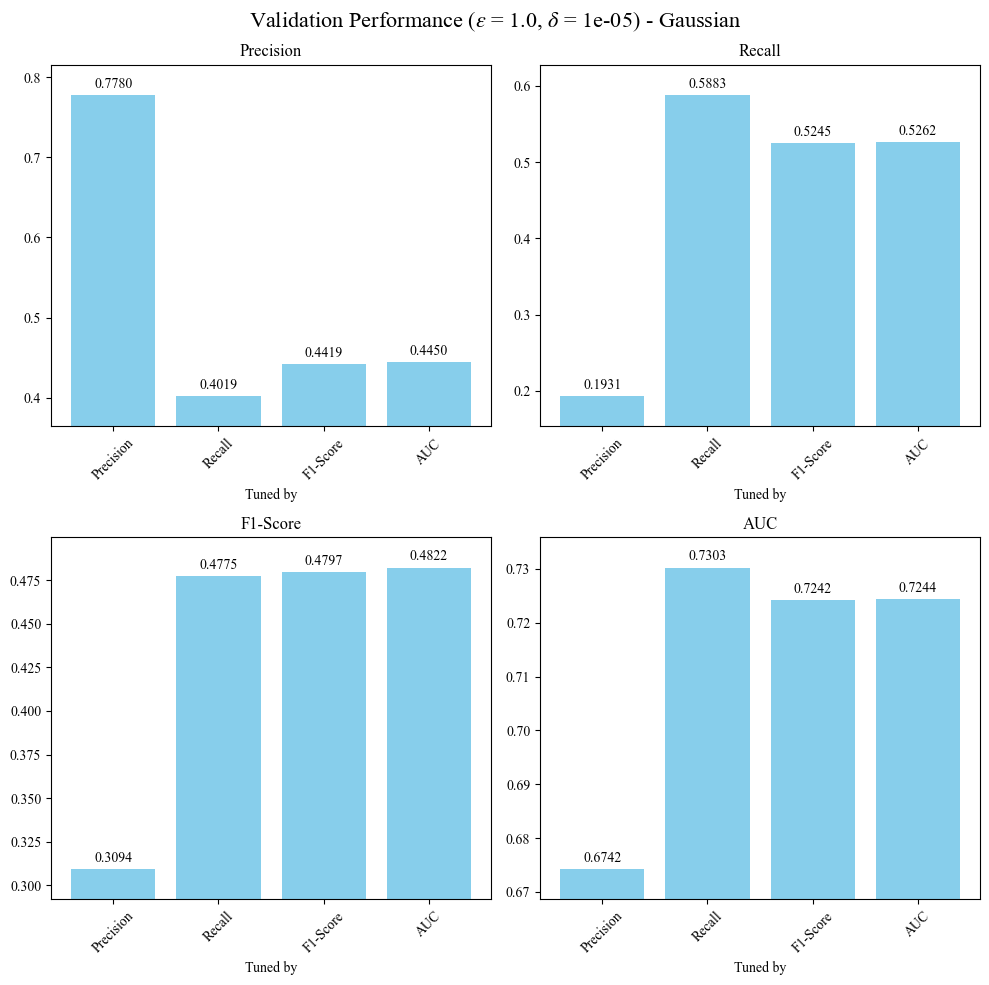

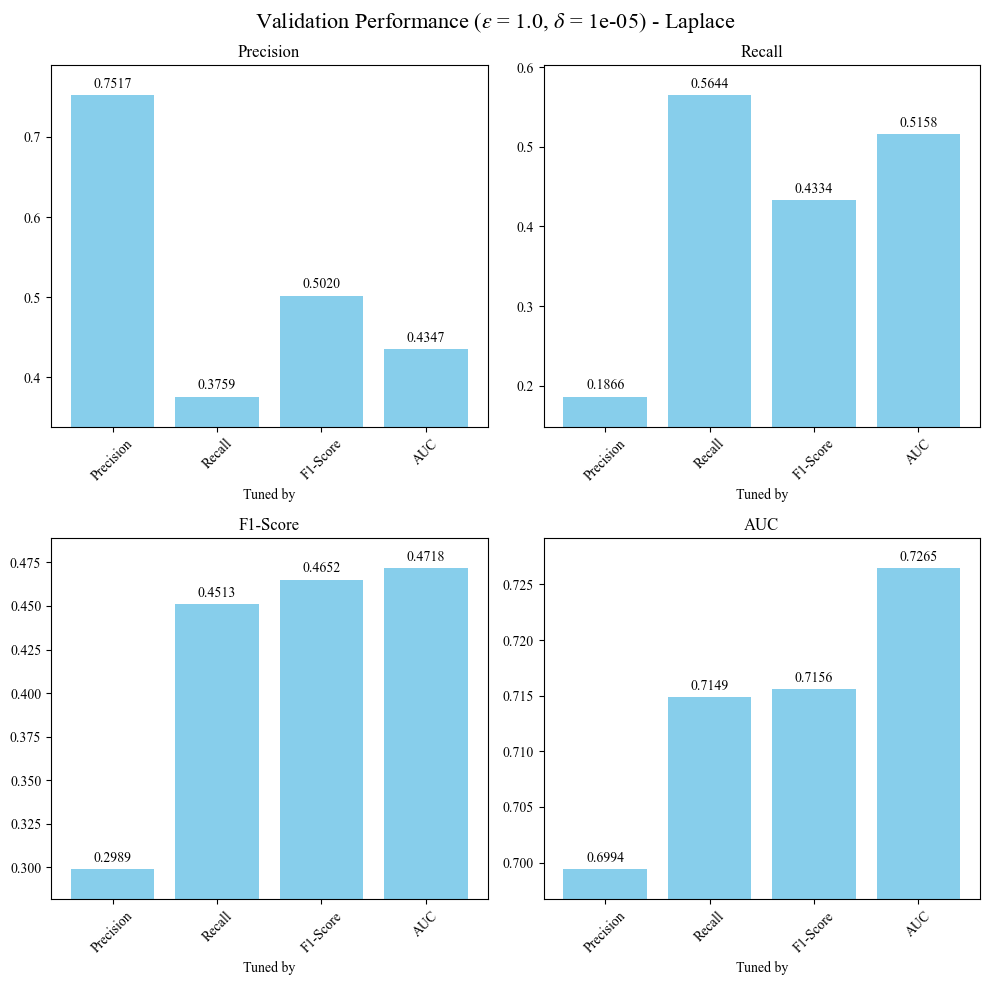

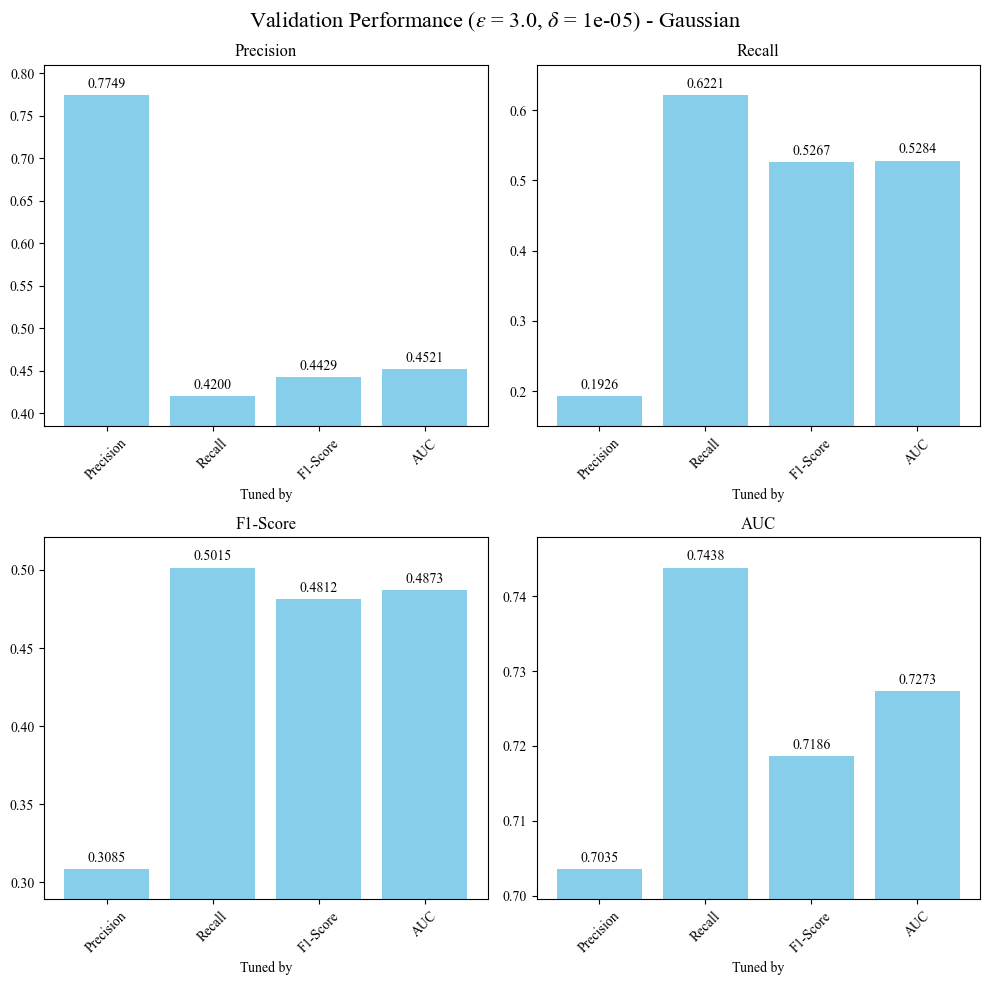

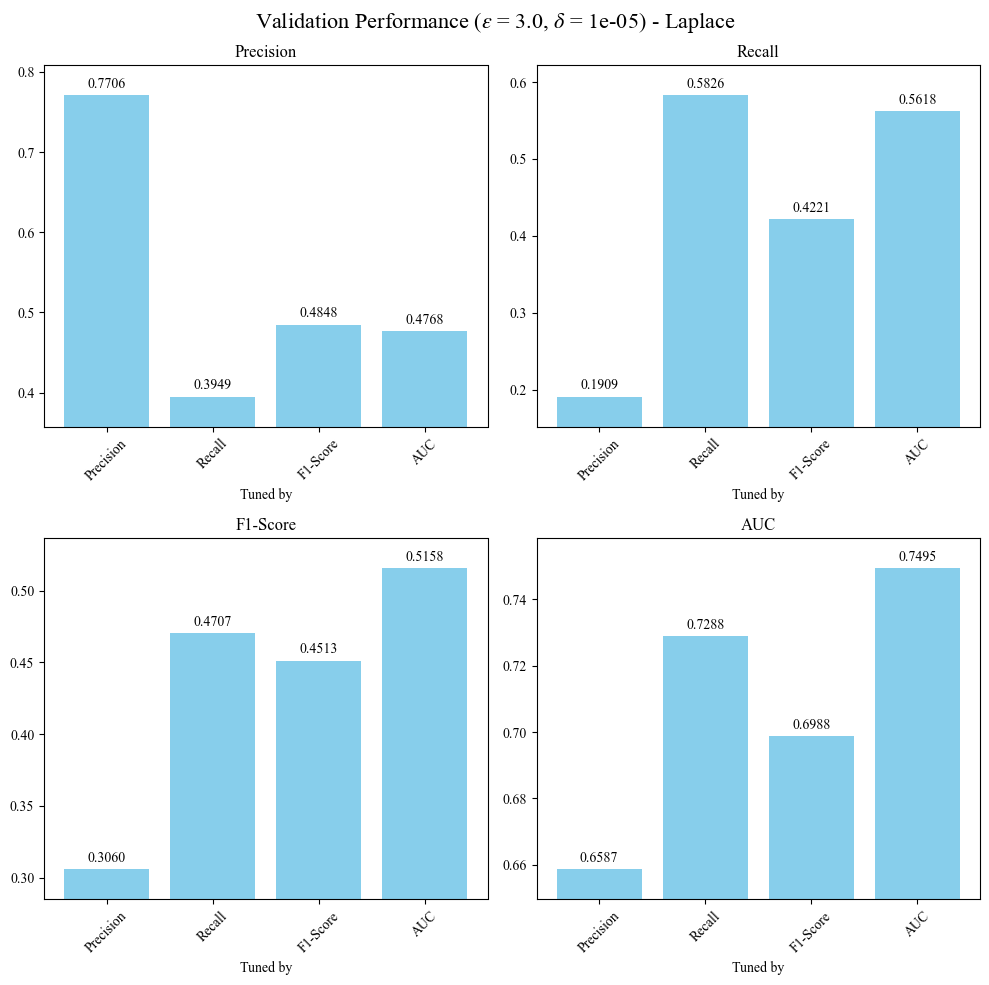

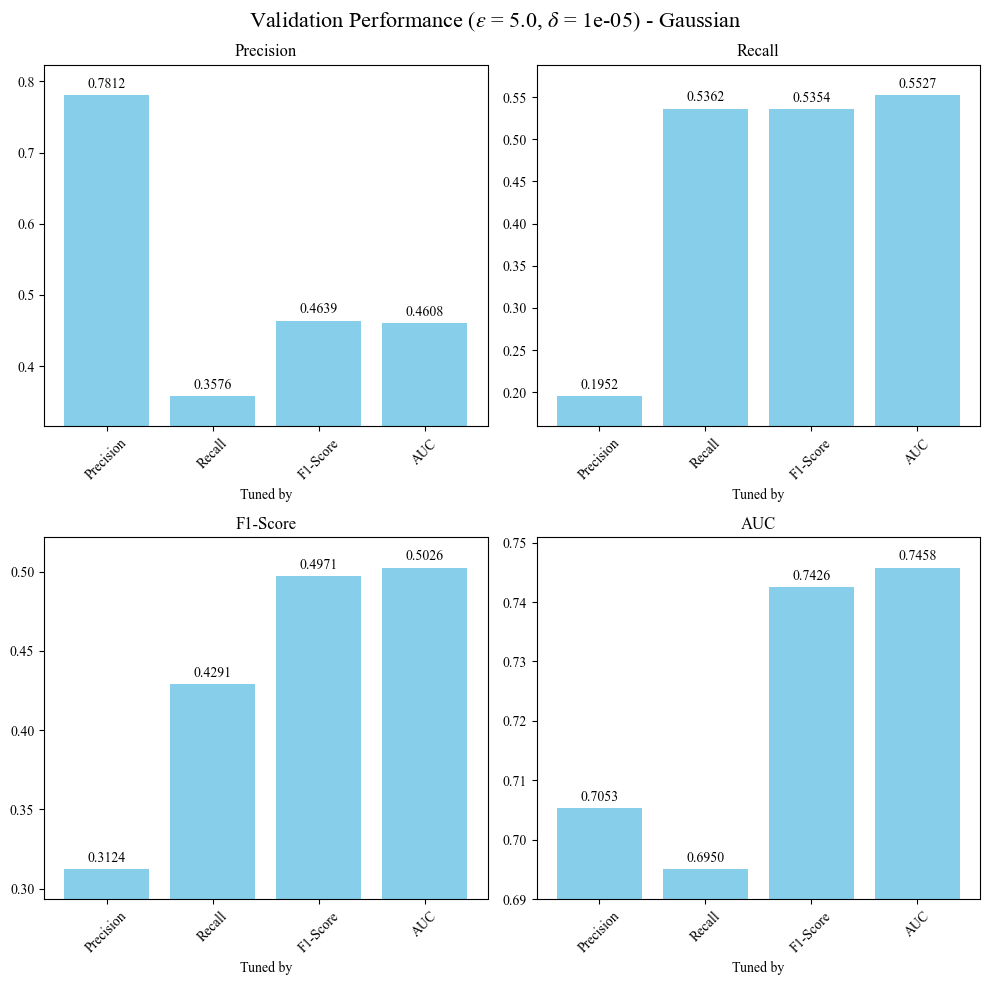

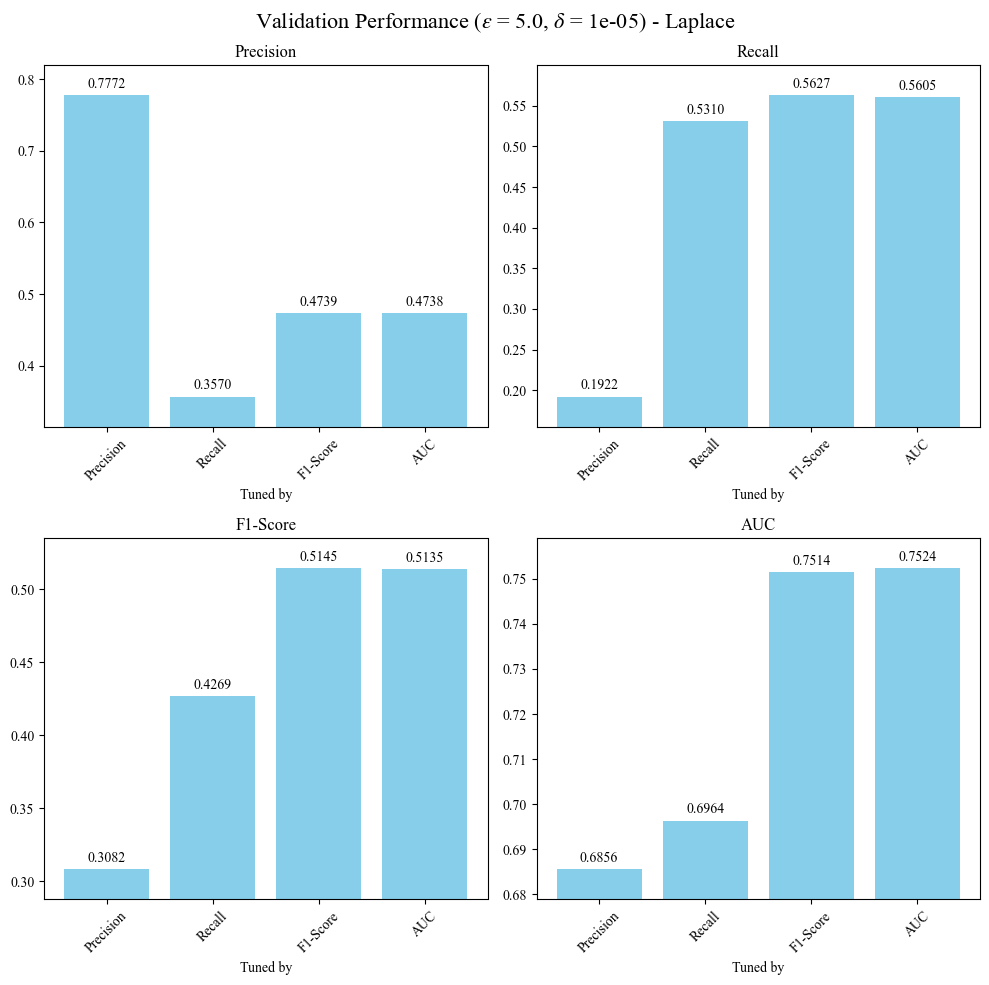

In [11]:
##################################################
## Plot a barplot of the validation performance ##
##################################################

valeval.plot_bar(eval_results, save=False)

### 3.4. Inspect Convergence of Bayesian Optimization

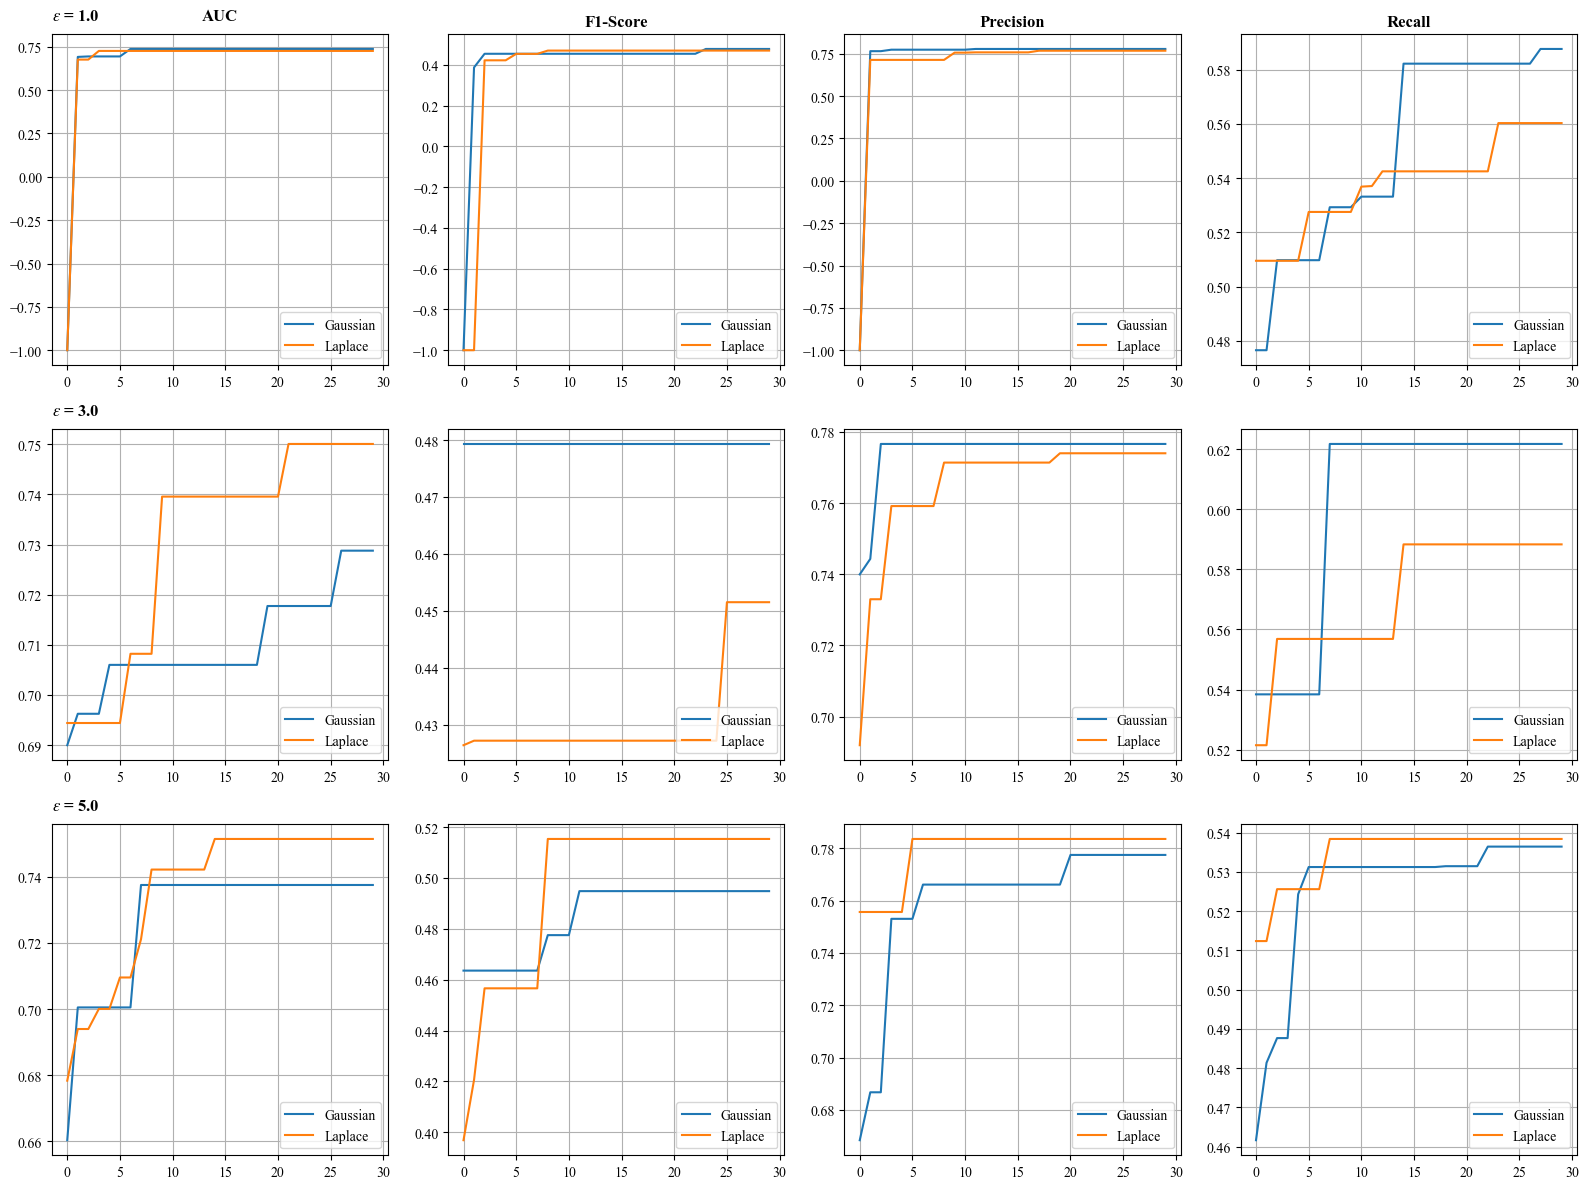

In [12]:
sorted_results = eval_results.sort_values(by=["tuned_by", "epsilon"], ascending=True).reset_index(drop=False)
sorted_results["metric_key"] = sorted_results["tuned_by"].str.lower().str.replace("-", "_")

# Choose 3 rows (epsilon) × 4 columns (tuned_by), fixed layout
unique_epsilons = sorted(sorted_results["epsilon"].unique())     # pick top 3
unique_metrics = sorted(sorted_results["tuned_by"].unique())     # pick top 4

fig, axes = plt.subplots(nrows=len(unique_epsilons), ncols=len(unique_metrics), figsize=(4*len(unique_metrics), 4*len(unique_epsilons)), squeeze=False)

for row_idx, epsilon in enumerate(unique_epsilons):
    for col_idx, tuned_by in enumerate(unique_metrics):
        ax = axes[row_idx][col_idx]
        metric_key = tuned_by.lower().replace("-", "_")

        # Filter for this subplot's metric and epsilon
        subset = sorted_results[(sorted_results["epsilon"] == epsilon) & (sorted_results["tuned_by"] == tuned_by)]

        for mechanism in ["gaussian", "laplace"]:
            sub = subset[subset["noise_mechanism"] == mechanism]
            if not sub.empty:
                for _, row in sub.iterrows():
                    version = row["version"]
                    file_path = f"../experiments/hyperparam_tune/posthoc_dp/bayes_{metric_key}_{version}.csv"
                    if os.path.exists(file_path):
                        df = pd.read_csv(file_path)
                        df["best_so_far"] = df[metric_key].cummax()
                        ax.plot(df.index, df["best_so_far"], label=mechanism.capitalize())
        
        if row_idx == 0:
            ax.set_title(tuned_by, fontsize=12, fontweight='bold')
        if col_idx == 0:
            ax.set_title(f"$\\varepsilon$ = {epsilon}", loc='left', fontsize=12, fontweight='bold', pad=10)
        
        ax.grid(True)
        ax.legend(loc='lower right')

# Hide any unused axes if needed (not needed here since fixed 3×4)
plt.tight_layout()
plt.show()

### 3.5. Check Convergence of the Final Training

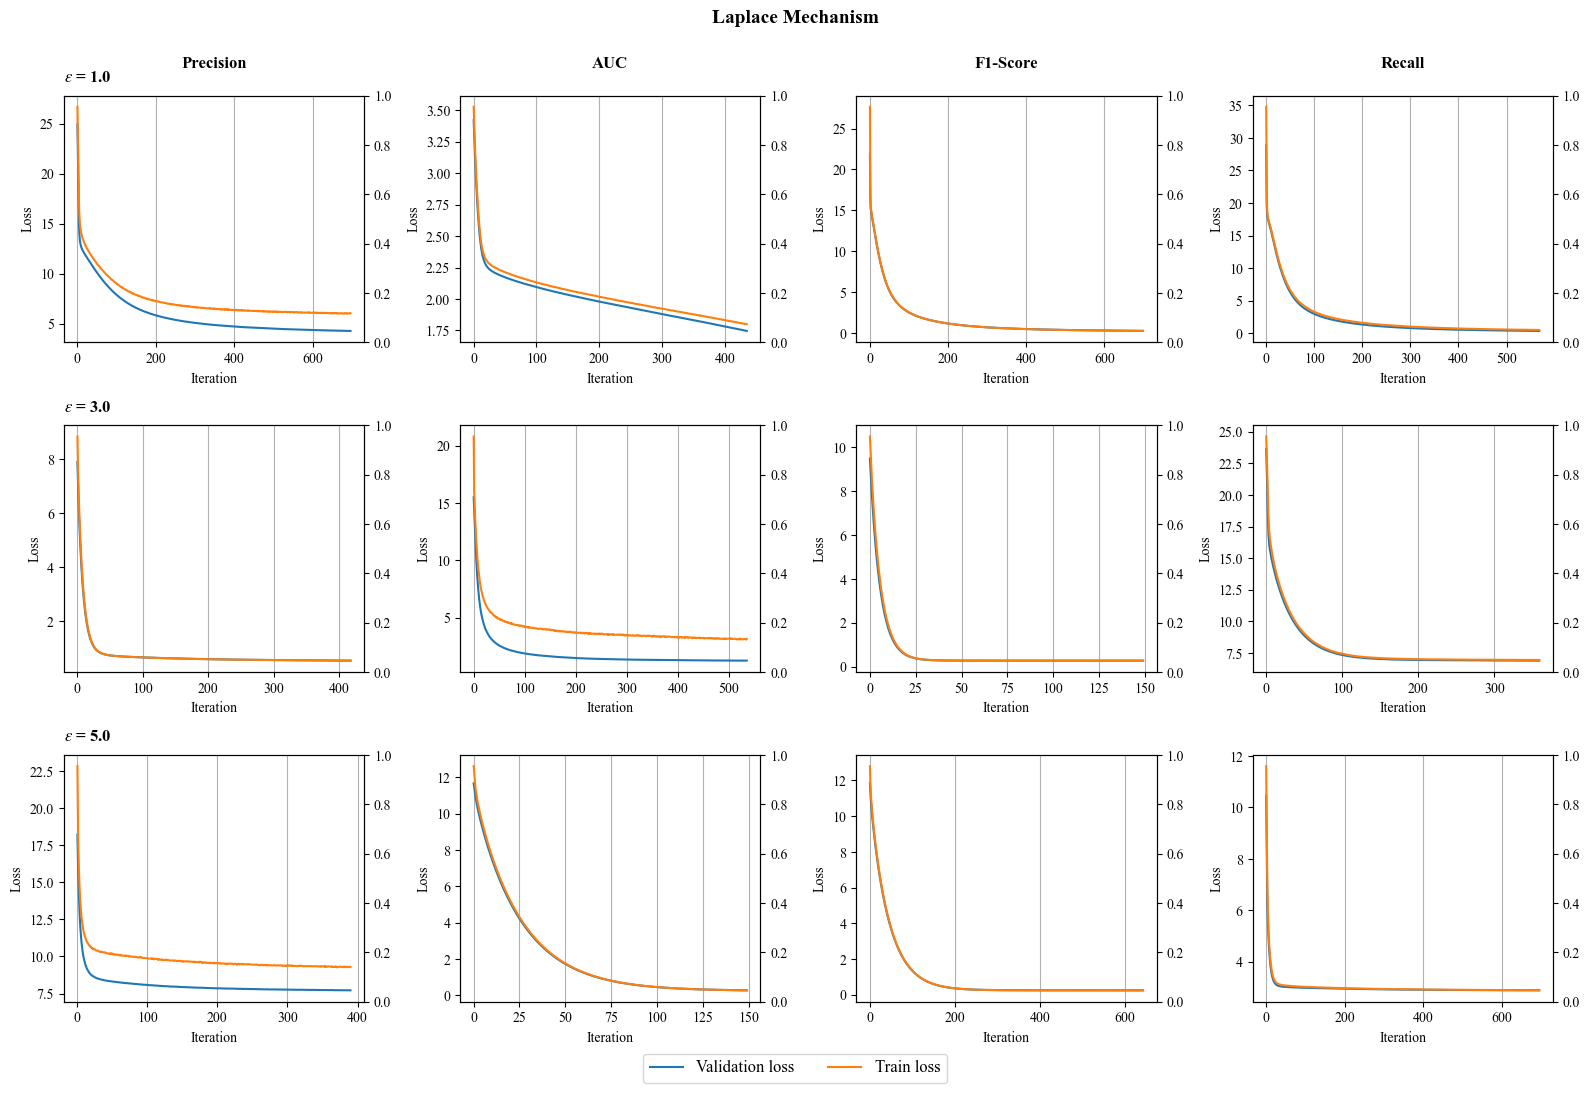

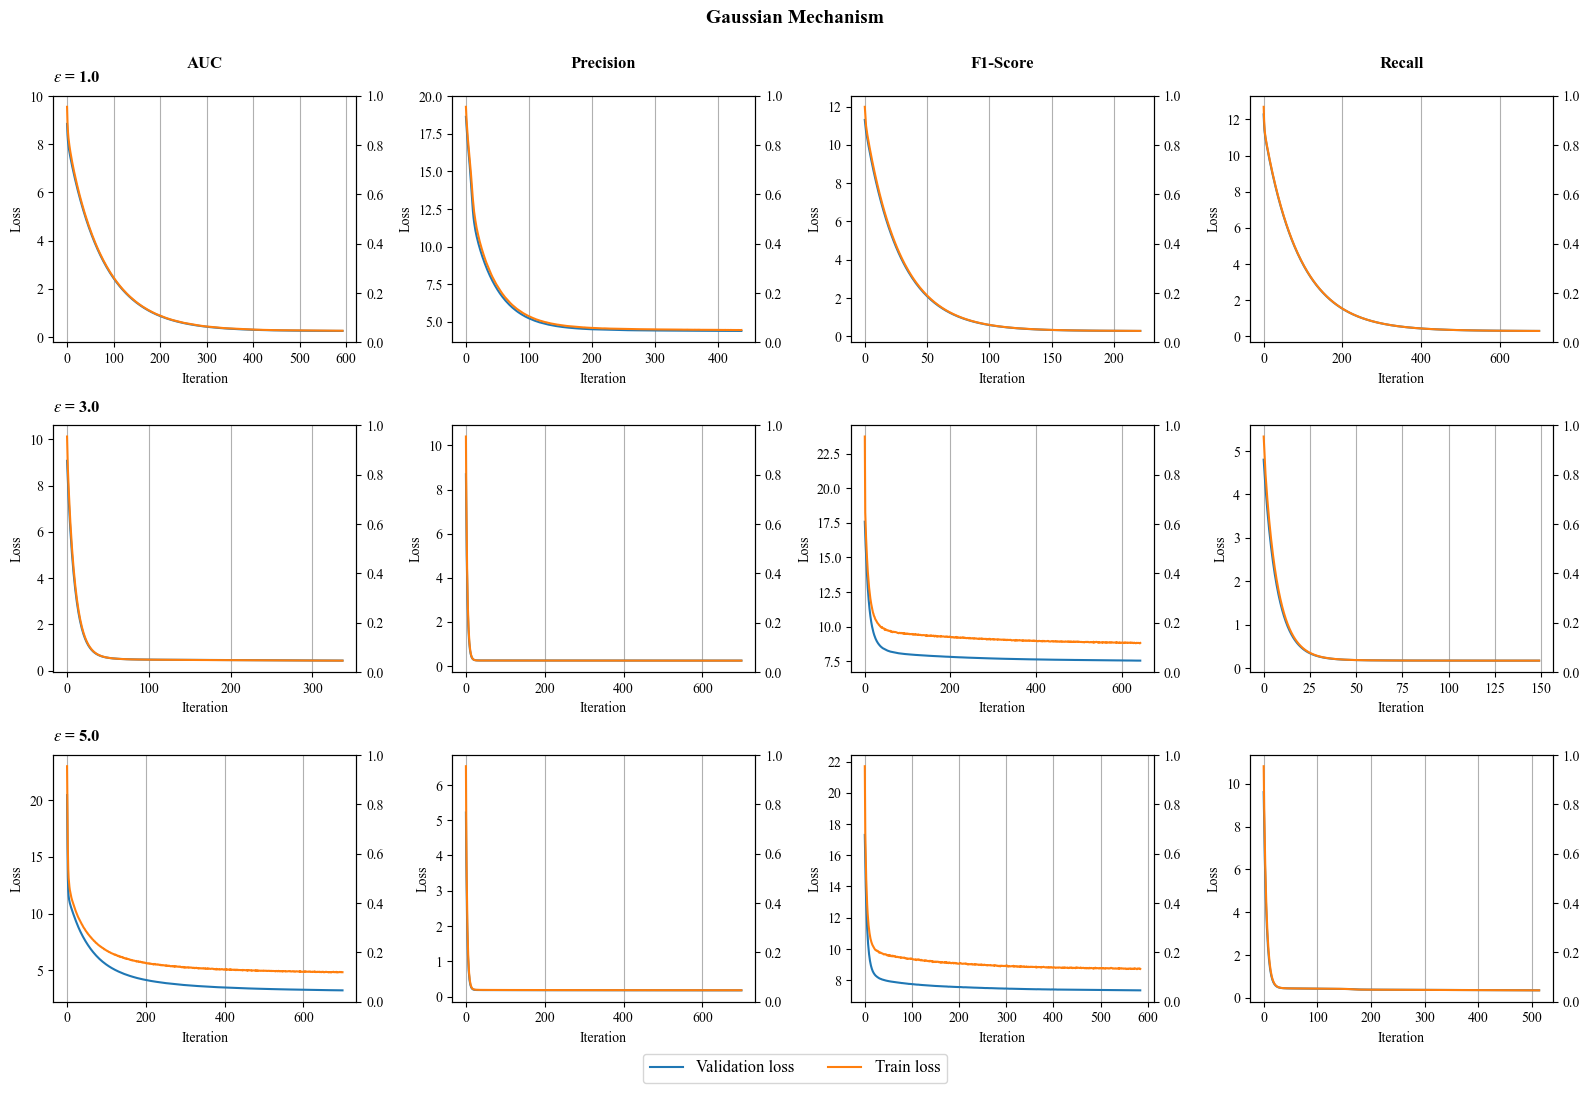

In [14]:
sorted_results = eval_results.sort_values(by=["epsilon"], ascending=True).reset_index(drop=False)

# Unique values
noise_mechanisms = ["laplace", "gaussian"]
n_cols = len(unique_metrics)  # updated to match unique metrics
n_rows = len(unique_epsilons)  # updated to match unique epsilons

# Loop over each noise mechanism and make one figure each
for mechanism in noise_mechanisms:
    filtered_results = sorted_results[sorted_results["noise_mechanism"] == mechanism]
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 3.5 * n_rows))
    axes = axes.flatten()

    for i in range(n_rows * n_cols):
        ax1 = axes[i]
        ax2 = ax1.twinx()

        if i >= len(filtered_results):
            fig.delaxes(ax1)
            continue

        row = filtered_results.iloc[i]
        version = row["version"]
        epsilon = row["epsilon"]
        metric = row["tuned_by"]

        # Load tracking file for this version
        folder = "../experiments/tracking"
        pattern = os.path.join(folder, f"{version}_posthoc.csv")
        files = glob.glob(pattern)
        if not files:
            continue

        results_df = pd.read_csv(files[0])  # assume one file per version

        # Plot loss
        val = ax1.plot(results_df.index, results_df["val_loss"], label='Validation loss')
        train = ax1.plot(results_df.index, results_df["train_loss"], label='Train loss')
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('Loss')
        ax1.tick_params(axis='y')

        # Combine all lines for legend
        lns = val + train
        labs = [l.get_label() for l in lns]

        # Titles and labels
        if i // n_cols == 0:
            ax2.set_title(metric, fontsize=12, pad=20, fontweight='bold')
        if i % n_cols == 0:
            ax1.set_title(f"$\\varepsilon$ = {epsilon}", loc='left', fontsize=12, fontweight='bold', pad=10)

        ax1.grid(True, axis='x')

    # Add global legend
    fig.legend(lns, labs, loc='lower center', bbox_to_anchor=(0.5, -0.03),
               ncol=3, fontsize=12)

    fig.suptitle(f"{mechanism.capitalize()} Mechanism", fontsize=14, fontweight='bold', y=1)
    plt.tight_layout()
    plt.show()